In [1]:
# Imports
%load_ext autoreload
%autoreload 2
from gwBackground import *
import matplotlib.pyplot as plt
import numpy as np
from pygwb.constants import H0
H0_si = H0.si.value
import sys
sys.path.append('../code/')

# Plot formatting
import matplotlib 
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fontsize = 9
params = {
   'axes.labelsize': fontsize,
   'font.size': fontsize,
   'legend.fontsize': 8,
   'xtick.labelsize': fontsize,
   'ytick.labelsize': fontsize,
   'axes.titlesize':fontsize,
   'lines.linewidth':1,  
   'xtick.direction':'in',
   'ytick.direction':'in',
   'font.family':'Serif',
   'font.serif':'Hoefler Text',
   'axes.grid':True,
   'figure.figsize': (6.75, 4),
   'figure.dpi':250,
   'mathtext.fontset':'cm'
}

for param in params.keys():
    matplotlib.rcParams[param] = params[param]

In [3]:
T_obs = (1/365.25/24) # in years

from bilby.gw.prior import Cosmological
# Define redshift prior
class PowerLawRedshiftPrior(Cosmological):
    def __init__(self, minimum, maximum, R0, alpha, beta, zp, **kwargs):
        """
        R0 is in units of Gpc^{-3} yr^{-1}
        """
        self.R0 = R0 * 1e-9 # convert to Mpc^{-3} yr^{-1}
        self.alpha = alpha
        self.beta = beta
        self.zp = zp
        super(PowerLawRedshiftPrior, self).__init__(minimum=minimum, maximum=maximum, **kwargs)
        
    def _get_redshift_arrays(self):
        zs = np.linspace(self._minimum['redshift'] * 0.99,
                         self._maximum['redshift'] * 1.01, 1000)
        C = 1 + (1 + self.zp)**(-self.alpha - self.beta)
        p_dz = (1/(1+zs)) * C * ((self.R0 * (1 + zs)**(self.alpha))/(1 + ((1 + zs)/(1 + self.zp))**(self.alpha + self.beta))) * self.cosmology.differential_comoving_volume(zs).value
        return zs, p_dz

# Create priors
priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=5, maximum=50)
priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors['chi_1'] = 0
priors['chi_2'] = 0
priors['theta_jn'] = bilby.core.prior.Uniform(0, 2*np.pi, name='theta_jn') # bilby.core.prior.Cosine()
priors['redshift'] = PowerLawRedshiftPrior(R0=28.3, alpha=1.9, beta=3.4, zp=2.4, name='redshift', minimum=0, maximum=10)

14:06 bilby INFO    : Using aligned spin prior
14:06 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [4]:
# def calculate_num_injections(T_obs, priors):
#    """
#    Calculate the number of mergers in a given time T_obs.
#     
#    Parameters
#    =======
# 
#    T_obs : ``float``
#        Observation time, in years.
#    priors : dictionary
#        Dictionary of priors to consider. Must include redshift prior.
#     
#    Returns
#    =======
#    
#    N : ``int``
#        Number of mergers.
#    """
# 
#    zs, p_dz = priors['redshift']._get_redshift_arrays()
#    p_dz_centers = (p_dz[1:] + p_dz[:-1])/2.
#    total_sum = np.sum(np.diff(zs) * p_dz_centers)
#    N = T_obs * total_sum
#    return N

In [ ]:
def calculate_num_injections(T_obs, zs, p_dz):
    """
    Calculate the number of mergers in a given time T_obs.
    
    Parameters
    =======
    
    T_obs : ``float``
        Observation time, in years.
    zs : ``np.array``
        Array of merger redshifts.
    p_dz : ``np.array``
        Redshift probability distribution.
        
    Returns
    =======
    
    N : ``int``
        Number of mergers.
    """
    
    p_dz_centers = (p_dz[1:] + p_dz[:-1])/2.
    total_sum = np.sum(np.diff(zs) * p_dz_centers)
    N = T_obs * total_sum
    return N

In [5]:
N_inj = calculate_num_injections(T_obs, priors)
print('Number of injections: ' + str(N_inj))

Number of injections: 0.6511213642759479


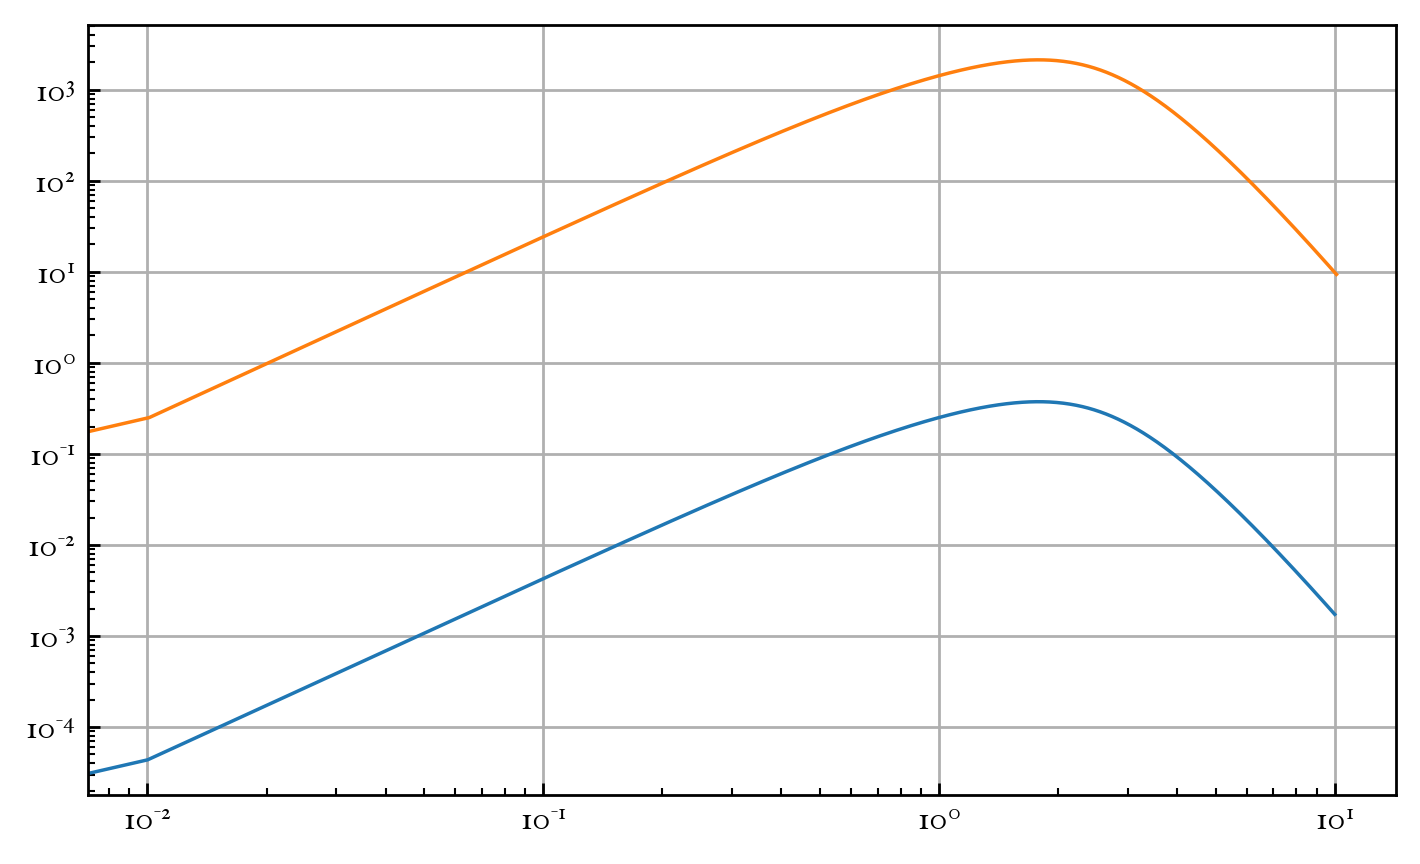

In [6]:
# Plot unnormalized and normalized redshfit prior
zs = np.linspace(0,10,1000)
plt.loglog(zs, priors['redshift'].prob(zs))
plt.loglog(priors['redshift']._get_redshift_arrays()[0], priors['redshift']._get_redshift_arrays()[1])